# Basin-level tally of biomass for each landcover
#### Overlay LC to create mask applied before for zonal stats of AGB
* to run zonal stats for certain land cover zones in WorldCover s3 dataset

In [57]:
def do_imports():
    import geopandas as gpd
    import pandas as pd
    import rasterio
    import glob
    import os
    #import rioxarray
    import fiona

    import sys
    sys.path.append('/projects/icesat2_boreal/lib')
    sys.path.append('/projects/Developer/icesat2_boreal/lib')
    import ExtractUtils
    import CovariateUtils

    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.colors import ListedColormap, BoundaryNorm
    import rasterio
    from rasterio.plot import show_hist, show
    import numpy.ma as ma
    print("Importing packages complete.")
try:
    do_imports()
except ModuleNotFoundError:
    print('Need to pip install packages...')
    !pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
    do_imports()
    
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

plt.rc('font', **font)

Importing packages complete.


## Set up output directories, covars footprint vector, and tiles vector input

In [59]:
# a writable outdir
OUTDIR_MAIN = '/projects/my-public-bucket/analyze_agb'
OUTDIR_MASK_AGB = os.path.join(OUTDIR_MAIN, 'output_mask_agb')

# Setup access to ESA Worldcover s3 rasters
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

# ESA Worldcover v100 2020
COVAR_FOOTPRINTS_FN = os.path.join(OUTDIR_MAIN,'footprints_v100_2020_v100_2020_map-s3.gpkg')

# Get boreal tiles to use CRS for reprojecting HYDROBASINS
boreal_tiles = gpd.read_file('/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg')

https://gis.stackexchange.com/questions/345917/overlay-two-raster-geotiffs-using-rasterio-mask

### Establish some broad DOMAIN in which to collect regions

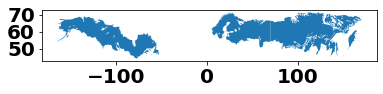

In [60]:
if False:
    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres") )
    alaska = world[world.name == 'United States of America'].explode().cx[-170:-50, 50:90]
    canada = world[world.name == 'Canada']
    canada_alaska = pd.concat([alaska, canada])
    canada_alaska.plot()
    
# Get boreal domain from wwf 
boreal_gdf = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/wwf_circumboreal_Dissolve.geojson')
boreal_gdf.plot()

### Get the Worldcover covariate tiles

In [61]:
# Build a VRT of the LC on s3?
covar_footprint_tiles = gpd.read_file(COVAR_FOOTPRINTS_FN)
covar_footprint_tiles.head()

,footprint_name,path,file,s3_path,geometry
0,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E006_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((9.00000 0.00000, 9.00000 3.00000, 6...."
1,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E009_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((12.00000 0.00000, 12.00000 3.00000, ..."
2,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E012_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((15.00000 0.00000, 15.00000 3.00000, ..."
3,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E015_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((18.00000 0.00000, 18.00000 3.00000, ..."
4,None,https://esa-worldcover.s3.eu-central-1.amazona...,ESA_WorldCover_10m_2020_v100_N00E018_Map.tif,s3://esa-worldcover/v100/2020/map/ESA_WorldCov...,"POLYGON ((21.00000 0.00000, 21.00000 3.00000, ..."


### Subset covariate tiles by broad domain (boreal)
* Build the spatial selector with 'intersects'
* do the subset accord to region (where region is identified with the spatial selector)

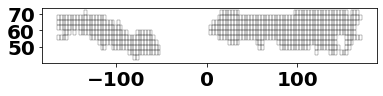

In [62]:
tile_group_region_string = 'wwf_boreal'

boreal_gdf['dissolve_field'] = 'for intersect'

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles.intersects(boreal_gdf.dissolve(by='dissolve_field').iloc[0].geometry)
covar_footprint_tiles_subset = covar_footprint_tiles[selector]
covar_footprint_tiles_subset.boundary.plot(linewidth=0.25, color='black')

### Subset covariate tiles by sub-domain

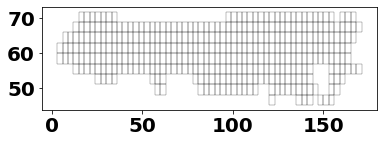

In [63]:
SUB_DOMAIN = 'eurasia'#'america' #eurasia

tile_group_region_string = tile_group_region_string + '_' + SUB_DOMAIN

if 'america' in SUB_DOMAIN:
    xmin, xmax, ymin, ymax = [-179, -50, 30, 90]
if 'eurasia' in SUB_DOMAIN:
    xmin, xmax, ymin, ymax = [-20, 179, 30, 90]

SUB_DOMAIN_selection_geometry = boreal_gdf.cx[xmin:xmax, ymin:ymax].iloc[0].geometry

# Do a dissolve so that there is only 1 polygon to intersect; .iloc[0]
selector = covar_footprint_tiles_subset.intersects(SUB_DOMAIN_selection_geometry)

covar_footprint_tiles_subset = covar_footprint_tiles_subset[selector]
covar_footprint_tiles_subset.boundary.plot(linewidth=0.25, color='black')

In [64]:
# cog bands dict
bands_dict = {'1': 'esa_worldcover_v100_2020'
             }


### Subset the regions by sub domain


In [65]:
# Make GPKG of a merge all hydrobasin regions for a certain level
NORTHERN_REGION_IDS = ['ar','as','eu','na','si']
HYBAS_LEVEL_STR = 'lev06'
OUT_HYBAS_NORTHERN_FN = os.path.join(OUTDIR_MAIN, 'input_zones', f'hybas_lake_NORTHERN_{HYBAS_LEVEL_STR}_{SUB_DOMAIN}_vc1.gpkg')

if not os.path.isfile(OUT_HYBAS_NORTHERN_FN):
    pd.concat([gpd.read_file(f).cx[xmin:xmax, ymin:ymax] for f in [glob.glob(f'/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_{hybas_reg}_{HYBAS_LEVEL_STR}_v1c.shp')[0] for hybas_reg in NORTHERN_REGION_IDS]]).to_file(OUT_HYBAS_NORTHERN_FN, driver='GPKG')
   # pd.concat([gpd.read_file(f) for f in glob.glob(f'/projects/my-public-bucket/analyze_agb/hydrobasins/hybas_lake_*_{HYBAS_LEVEL_STR}_v1c.shp')]).to_file(OUT_HYBAS_GLOBAL_FN, driver='GPKG')
print(f"{OUT_HYBAS_NORTHERN_FN}")

/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_eurasia_vc1.gpkg


### Establish the clip INDEX_FN
* the GPKG that holds 1 specific clip polygon

In [66]:
CLIP_INDEX_DICT_LIST = [
    {
        'ID_COL_NAME': 'HYBAS_ID',
        'ID': None, #7060157640 4070084980 #4070000010,
        'ID_NAME': HYBAS_LEVEL_STR,
        'INDEX_LYR': None,
        'INDEX_FN': OUT_HYBAS_NORTHERN_FN, #f'/projects/my-public-bucket/analyze_agb/hydrobasins/{HYBAS_FILE}.shp'
        'ADD_STR': "-" + tile_group_region_string + '-reprj',
        'INDEX_REPRJ_FN': OUT_HYBAS_NORTHERN_FN.replace('.gpkg', "-" + tile_group_region_string + '-reprj' + '.gpkg')
    },
    {
        'ID_COL_NAME': 'tile_num',
        'ID': None,
        'ID_NAME': 'LVIS flightlines',
        'INDEX_LYR': 'LVISF2_2017',
        'INDEX_FN': '/projects/my-public-bucket/LVIS_ABoVE_spatial_footprints_2017_2019.gpkg',
        
        'ADD_STR': '',
        'INDEX_REPRJ_FN': ''
    },
    {
        'ID_COL_NAME': 'tile_num',
        'ID': None , #3417, # 4253
        'ID_NAME': 'boreal tiles',
        'INDEX_LYR': None, 
        'INDEX_FN': '/projects/my-public-bucket/boreal_tiles_v003.gpkg', #<---has to be writable, since the reprojected verion of this file will be written next to it
        'ADD_STR': '',
        'INDEX_REPRJ_FN': ''

    }  ,
    {
        'ID_COL_NAME': 'tile_num',
        'ID': 12967,
        'ID_NAME': 'DEM tiles',
        'INDEX_LYR': None,
        'INDEX_FN': '/projects/shared-buckets/lduncanson/dem30m_tiles_v2.geojson', # change the dir path to one that is writable
        'ADD_STR':'',
        'INDEX_REPRJ_FN': ''
    }
]

CLIP_INDEX_DICT = CLIP_INDEX_DICT_LIST[0]
CLIP_INDEX_DICT

{'ID_COL_NAME': 'HYBAS_ID',
 'ID': None,
 'ID_NAME': 'lev06',
 'INDEX_LYR': None,
 'INDEX_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_eurasia_vc1.gpkg',
 'ADD_STR': '-wwf_boreal_eurasia-reprj',
 'INDEX_REPRJ_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_eurasia_vc1-wwf_boreal_eurasia-reprj.gpkg'}

In [67]:
#import fiona
#infile_fn = '/projects/my-public-bucket/LVIS_ABoVE_spatial_footprints_2017_2019.gpkg'
#infile_fn='/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_vc1-wwf_boreal_america-reprj.gpkg'
#fiona.listlayers(CLIP_INDEX_DICT['INDEX_REPRJ_FN'])
###fiona.remove(infile_fn, layer='LVIS_ABoVE_spatial_footprints_2017_2019')
#gpd.read_file(infile_fn, rows=1, layer='LVISF2_2017')

### Read and subset the clipping INDEX vector

In [68]:
print(f'Reading vector...')
#if CLIP_INDEX_DICT['ID_COL_NAME'] is not None:,
z = gpd.read_file(CLIP_INDEX_DICT['INDEX_FN'], layer=CLIP_INDEX_DICT['INDEX_LYR'])

print(f'Checking columns...')
if CLIP_INDEX_DICT['ID_COL_NAME'] not in z.columns.tolist():
    
    print('Adding column...')
    NEW_INDEX_COLUMN_NAME = 'tile_num'
    z[NEW_INDEX_COLUMN_NAME] = z.index
    CLIP_INDEX_DICT['ID_COL_NAME'] = NEW_INDEX_COLUMN_NAME
    z.to_file(CLIP_INDEX_DICT['INDEX_FN'], driver='GPKG', layer=CLIP_INDEX_DICT['INDEX_LYR'], overwrite=True)

print(f'Checking CRS units of clipping GPKG...')
INPUT_CRS_UNITS = z.crs.axis_info[0].unit_name
   
print(f'Making spatial subset of clipping GPKG...')
if 'degree' not in INPUT_CRS_UNITS:
    
   # print(f'Reading...')
    #z = gpd.read_file(CLIP_INDEX_DICT['INDEX_FN'], layer=CLIP_INDEX_DICT['INDEX_LYR'])
          
    print(f'Reprojecting to 4326, then subset by sub-domain...')
    z = z.to_crs(4326)
    
#else:   
    #print(f"Reading and clipping to sub-domain simultaneously via mask on read...")
    ## Read in spatial subset to get the hydrobasin SELECTION 
    #z = gpd.read_file(CLIP_INDEX_DICT['INDEX_FN'], mask=SUB_DOMAIN_selection_geometry, layer=CLIP_INDEX_DICT['INDEX_LYR']) #
    
print("Subset by SUB_DOMAIN...")
selector = z.intersects(SUB_DOMAIN_selection_geometry)
z = z[selector]

if 'LAKE' in z.columns.tolist():
    # Remove lakes!
    z = z[z.LAKE==0]

if 'degree' in INPUT_CRS_UNITS:

    print('Reprojecting to equal area and writing reprojected output...')
    # Reproject hydrobasin SELECTION to equal area (boreal_tiles)
    z.to_crs(boreal_tiles.crs).to_file(CLIP_INDEX_DICT['INDEX_REPRJ_FN'], driver='GPKG', layer=CLIP_INDEX_DICT['INDEX_LYR'])

    # Read and plot the basin in orig prj
    #z = gpd.read_file(INDEX_FN).to_crs(4326)

    # Now change this variable back to what BUILD_STACK_DICT wants
    # Now you have INDEX_FN in the boreal_tiles crs
    INDEX_FN = CLIP_INDEX_DICT['INDEX_REPRJ_FN']
else:
    INDEX_FN = CLIP_INDEX_DICT['INDEX_FN']

    
# The INDEX_LYR comes off the INDEX_FN set just above...
if CLIP_INDEX_DICT['INDEX_LYR'] is None:
    print('Specify the layer name of the GPKG...')
    INDEX_LYR = os.path.split(INDEX_FN)[1].split('.gpkg')[0]
else:
    INDEX_LYR = CLIP_INDEX_DICT['INDEX_LYR']
    
print("Done.")

Reading vector...
Checking columns...
Checking CRS units of clipping GPKG...
Making spatial subset of clipping GPKG...
Subset by SUB_DOMAIN...
Reprojecting to equal area and writing reprojected output...
Specify the layer name of the GPKG...
Done.


#### Randomly choose a feature to examine

In [69]:
if CLIP_INDEX_DICT['ID'] is None:
    # Get random feature (HYBAS)
    TILE_NUM = z.sample(n=1)[CLIP_INDEX_DICT['ID_COL_NAME']].to_list()[0]
else:
    TILE_NUM = CLIP_INDEX_DICT['ID']
    

print('Variables needed for input into BUILD_CLIP_DICT:')
ID_COL_NAME = CLIP_INDEX_DICT['ID_COL_NAME']
print(INDEX_FN)
print(INDEX_LYR)
print(ID_COL_NAME)
print(TILE_NUM)

Variables needed for input into BUILD_CLIP_DICT:
/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_eurasia_vc1-wwf_boreal_eurasia-reprj.gpkg
hybas_lake_NORTHERN_lev06_eurasia_vc1-wwf_boreal_eurasia-reprj
HYBAS_ID
3060604230


### Plot the selected clip extent

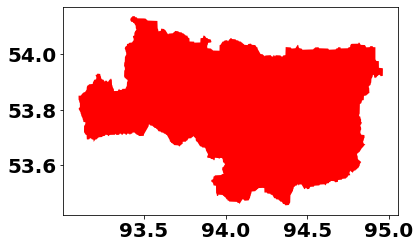

In [70]:
# Some extents will be near the -180 line and cause the plotting chunk to fail when doing the area calc.
# Try removing these polygons.
z[ z[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM  ].plot(color='red')

BAD_TILE_LIST = [3540,3634,3728,3823,3916,4004]


#### This will fail if the TILE_NUM specified is NOT in the data frame

Feature ID: 3060604230
Plot...


/opt/conda/lib/python3.7/site-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


Get area of basin...
Area (ha.) of feature 3060604230:		536911.94
Plot...


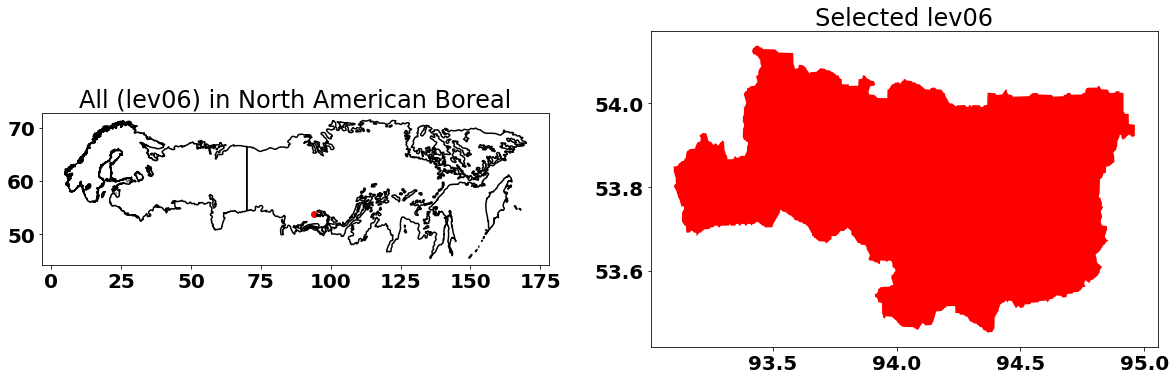

In [71]:
SHOW_FULL_EXTENT = False

print(f'Feature ID: {TILE_NUM}')

print('Plot...')
f, (ax1, ax2) = plt.subplots(figsize=(20, 25), ncols=2, nrows=1)
ax1.set_title(f"All ({CLIP_INDEX_DICT['ID_NAME']}) in North American Boreal")
ax2.set_title(f"Selected {CLIP_INDEX_DICT['ID_NAME']}")

hybas_border = gpd.read_file('/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev03_vc1.gpkg', bbox=(xmin, ymin, xmax, ymax))

hybas_border[hybas_border.intersects(SUB_DOMAIN_selection_geometry)].boundary.plot(linewidth=0.25, color='black', ax=ax1)

if SHOW_FULL_EXTENT:
    z.plot(color=None, linewidth=0.1, ax=ax1)
else:
    z[( z[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM) ].plot(color=None, linewidth=0.1, ax=ax1)
    
print('Get area of basin...')
basin_area_ha = z[( z[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM) ].to_crs(boreal_tiles.crs).area.to_list()[0] / 1e4
print(f"Area (ha.) of feature {TILE_NUM}:\t\t{round(basin_area_ha,2)}")

print('Plot...')
z[z[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM].to_crs(boreal_tiles.crs).centroid.to_crs(4326).plot(color='red', ax=ax1)
z[z[CLIP_INDEX_DICT['ID_COL_NAME']]==TILE_NUM].to_crs(boreal_tiles.crs).to_crs(4326).plot(color='red', ax=ax2)
boreal_gdf.cx[xmin:xmax, ymin:ymax].boundary.plot(color='black', marker = '---', ax=ax1)


## Setup input using hydrobasin as clip INDEX_FN
* reprojected to equal area using boreal_tile_index
* so output has same res, crs, and clip extent

In [79]:
#BUILD_STACK_DICT = {'INDEX_FN':INDEX_FN,'ID_COL_NAME':ID_COL_NAME,'TILE_NUM':TILE_NUM,'INDEX_LYR':INDEX_LYR,'RASTER_NAME':'','COVAR_TILE_FN':'', 'IN_COVAR_S3_COL':'', 'NODATA_VAL':''}
BUILD_STACK_DICT_LIST = [
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # Worldcover data is accessed via its footprint, with a 's3_path' col identifying the s3 locations of each tile
            'RASTER_NAME': 'esa_worldcover_v100_2020',
            'COVAR_TILE_FN': '/projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': 0,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # AGB data is accessed
            # This needs to be correctly in 4326 - 
            'RASTER_NAME': 'biomass_prelim',
            'COVAR_TILE_FN': '/projects/shared-buckets/lduncanson/DPS_tile_lists/AGB_tindex_master.json',
            'IN_COVAR_S3_COL': 's3',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
            {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # AGB data is accessed
            # This needs to be correctly in 4326 - 
            'RASTER_NAME': 'biomass_v2',
            'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/v2/AGB_tindex_master.json',
            'IN_COVAR_S3_COL': 's3_path',
            'NODATA_VAL': -9999,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': None
        },
        {
            'INDEX_FN':INDEX_FN,
            'ID_COL_NAME':ID_COL_NAME,
            'TILE_NUM':TILE_NUM,
            'INDEX_LYR':INDEX_LYR,
            # TerraPulse standage data is accessed via footprint with 'path' indicating s3 tile location
            'RASTER_NAME': 'standage',
            'COVAR_TILE_FN': '/projects/my-public-bucket/analyze_agb/footprints_terrapulse-pub-data_forest_age_v2.gpkg',
            'IN_COVAR_S3_COL': 'path',
            'NODATA_VAL': 255,
            'OUTPUT_CLIP_COG_FN':'',
            'CREDENTIALS_FN': '/projects/my-private-bucket/.aws/credentials'
        }
]

BUILD_STACK_DICT_LIST[2]

{'INDEX_FN': '/projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_eurasia_vc1-wwf_boreal_eurasia-reprj.gpkg',
 'ID_COL_NAME': 'HYBAS_ID',
 'TILE_NUM': 3060604230,
 'INDEX_LYR': 'hybas_lake_NORTHERN_lev06_eurasia_vc1-wwf_boreal_eurasia-reprj',
 'RASTER_NAME': 'biomass_v2',
 'COVAR_TILE_FN': '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/v2/AGB_tindex_master.json',
 'IN_COVAR_S3_COL': 's3_path',
 'NODATA_VAL': -9999,
 'OUTPUT_CLIP_COG_FN': '',
 'CREDENTIALS_FN': None}

## Run the basin clips of the rasters
run build_stack.py (now featuring a geom clip!) for ESA Worldcover and AGB

### Return extent clip COGs for all data sources in BUILD_STACK_DICT_LIST (loop)

In [80]:
for BUILD_STACK_DICT in BUILD_STACK_DICT_LIST:
    
    if False:
        # --Special temporary case
        # Uh oh, any mosiac json needs to have the correct projection set
        # TODO: fix the setting of the MosaicJson in 3_DPS_review_pmm_v3
        if BUILD_STACK_DICT['RASTER_NAME'] == 'biomass_prelim':

            x = gpd.read_file(COVAR_TILE_FN)
            print('Reset projection and reproject...')
            x = x.set_crs(boreal_tiles.crs, allow_override=True, inplace=True).to_crs(4326)

            # Write a new JSON that should have the prj set correctly in 4326
            COVAR_TILE_FN = os.path.join('/projects/my-public-bucket/analyze_agb' , os.path.split(COVAR_TILE_FN)[1])
            print(COVAR_TILE_FN)
            x.to_file(COVAR_TILE_FN, driver='GeoJSON', overwrite=True)

            ## Verify 4326
            #ax = x.plot()
            #z[z[ID_COL_NAME]==TILE_NUM].to_crs(4326).plot(color='red', ax=ax)

    # INDEX clip shapes should be in equal area
    # COVAR_TILE_FN tiles (of raster COGs) should be in 4326
    args = f"--in_tile_fn {BUILD_STACK_DICT['INDEX_FN']} \
    --in_tile_id_col {BUILD_STACK_DICT['ID_COL_NAME']} \
    --in_tile_num {BUILD_STACK_DICT['TILE_NUM']} \
    --tile_buffer_m 0 \
    --in_tile_layer {BUILD_STACK_DICT['INDEX_LYR']} \
    -o {OUTDIR_MASK_AGB} \
    --topo_off \
    --covar_src_name {BUILD_STACK_DICT['RASTER_NAME']} \
    --covar_tile_fn {BUILD_STACK_DICT['COVAR_TILE_FN']} \
    --in_covar_s3_col {BUILD_STACK_DICT['IN_COVAR_S3_COL']} \
    --input_nodata_value {BUILD_STACK_DICT['NODATA_VAL']} \
    --clip" #<-- testing a clip to polygon
    
    BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN'] = os.path.join( OUTDIR_MASK_AGB, f"{BUILD_STACK_DICT['RASTER_NAME']}_{BUILD_STACK_DICT['TILE_NUM']}_cog.tif")
    
    print(args)
    if BUILD_STACK_DICT['CREDENTIALS_FN'] is not None:
        aws_session = CovariateUtils.get_rio_aws_session_from_creds(BUILD_STACK_DICT['CREDENTIALS_FN'])
        with rio.Env(aws_session):
            !python /projects/Developer/icesat2_boreal/lib/build_stack.py $args
    else:
        !python /projects/Developer/icesat2_boreal/lib/build_stack.py $args

--in_tile_fn /projects/my-public-bucket/analyze_agb/input_zones/hybas_lake_NORTHERN_lev06_eurasia_vc1-wwf_boreal_eurasia-reprj.gpkg     --in_tile_id_col HYBAS_ID     --in_tile_num 3060604230     --tile_buffer_m 0     --in_tile_layer hybas_lake_NORTHERN_lev06_eurasia_vc1-wwf_boreal_eurasia-reprj     -o /projects/my-public-bucket/analyze_agb/output_mask_agb     --topo_off     --covar_src_name esa_worldcover_v100_2020     --covar_tile_fn /projects/my-public-bucket/analyze_agb/footprints_v100_2020_v100_2020_map-s3.gpkg     --in_covar_s3_col s3_path     --input_nodata_value 0     --clip
/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string
The covariate's filename(s) intersecting the 0 m bbox for tile id 3060604230:
 s3://esa-worldcover/v100/2020/map/E

IndexError: list index out of range

In [74]:
# For each clip INDEX (polygon) there are 2 corresponding output clipped COGs you need
BASIN_COG_DICT = {'landcover_cog_fn': '', 'biomass_cog_fn':''}
for BUILD_STACK_DICT in BUILD_STACK_DICT_LIST:
    if 'worldcover' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'landcover_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
    if 'biomass' in BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']:
        BASIN_COG_DICT.update({'biomass_cog_fn': BUILD_STACK_DICT['OUTPUT_CLIP_COG_FN']})
BASIN_COG_DICT

{'landcover_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/esa_worldcover_v100_2020_3060604230_cog.tif',
 'biomass_cog_fn': '/projects/my-public-bucket/analyze_agb/output_mask_agb/biomass_v2_3060604230_cog.tif'}

# Create extent report
### Open clipped Worldcover COG and corresponding AGB, loop over LC classes, masking, summing, etc

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 2569, 'height': 3875, 'count': 1, 'crs': CRS.from_wkt('PROJCS["unnamed",GEOGCS["GRS 1980(IUGG, 1980)",DATUM["unknown",SPHEROID["GRS80",6378137,298.257222101],TOWGS84[0,0,0,0,0,0,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",180],PARAMETER["standard_parallel_1",50],PARAMETER["standard_parallel_2",70],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'), 'transform': Affine(30.00556591808164, 0.0, -4242880.699603104,
       0.0, -30.00556591808164, 4711914.495080243), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}

Area (ha.) of extent 3060604230:		536911.9387934242

lc_arr shape: (3875, 2569)
{'driver': 'GTiff', 'dtype': 'float64', 'nodata'

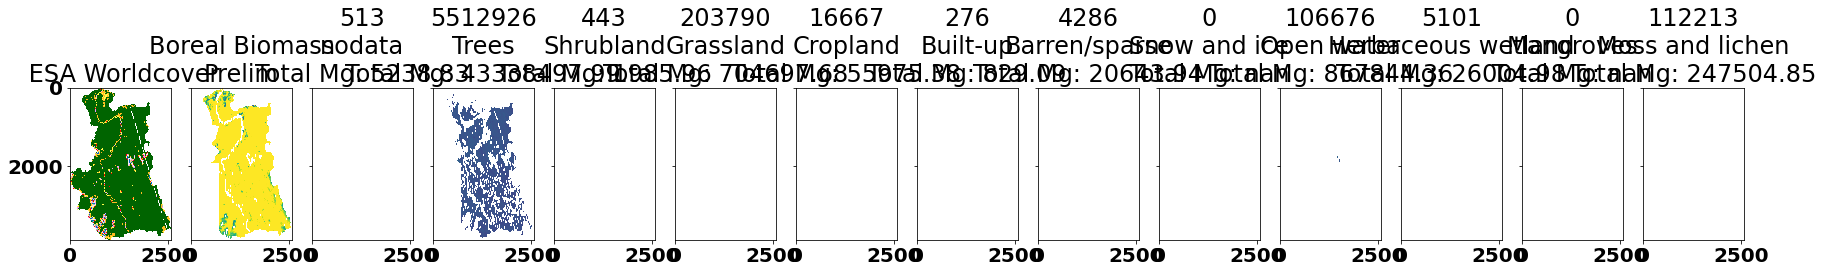

In [75]:
## %%time

# The area in hectares of a 30m pixel
area_pix_ha = 0.09

# The land cover values in which you want to summarize AGB
values_worldcover = [0,10,20,30,40,\
                     50,\
                     60,70,80,90,95,100] #'Trees', 'Shrubland', 'Grassland','Cropland', 'Barren / sparse vegetation', 'Herbaceous wetland','Moss and lichen'

fig, axes = plt.subplots(nrows=1, ncols=len(values_worldcover)+2, figsize=(30,10), sharex=True, sharey=True)

# Read back in the topo_stack_cog_fn and plot

with rasterio.open(BASIN_COG_DICT['landcover_cog_fn']) as dataset:

    print(dataset.profile)
    
    print(f"\nArea (ha.) of extent {TILE_NUM}:\t\t{basin_area_ha}")
    
    lc_arr = dataset.read(1)
    print(f"\nlc_arr shape: {lc_arr.shape}")
    
    # Plotting
    names_worldcover = ['nodata','Trees', 'Shrubland', 'Grassland','Cropland',\
                        'Built-up',
                        'Barren/sparse','Snow and ice','Open water','Herbaceous wetland','Mangroves','Moss and lichen']
    cols_worldcover = ['white',"#006400","#ffbb22","#ffff4c","#f096ff",\
                       "#fa0000",\
                       "#b4b4b4","#f0f0f0","#0064c8","#0096a0","#00cf75","#fae6a0"]
    #cols_worldcover = ["white","green","orange","yellow","purple","red","brown","gray","blue","pink","cyan","black"]
    #cols_mask = ["white", "red"]
    #values_mask = [0,1]

    cmap_worldcover = ListedColormap(cols_worldcover)
    norm_worldcover = BoundaryNorm(values_worldcover, len(cols_worldcover))

    #cmap_masked = ListedColormap(cols_mask)
    #norm_masked= BoundaryNorm(values_mask, len(cols_mask))
    
    axes[0].imshow(lc_arr, cmap=cmap_worldcover, norm=norm_worldcover)
    axes[0].set_title(f" ESA Worldcover")
    
    # Find sum of AGB per LC class
    # multiply by AGB values and sum
    with rasterio.open(BASIN_COG_DICT['biomass_cog_fn']) as dataset_agb:
        
        print(dataset_agb.profile)
        
        agb_arr = dataset_agb.read(1)
        print(f"agb nodata value: {dataset_agb.nodata}")
        
        #agb_arr = np.ma.masked_where( (lc_arr==0) | (agb_arr<0), agb_arr)
        agb_arr = np.ma.masked_where(  (agb_arr<0), agb_arr)
        total_mg_all = np.nansum(agb_arr)
        
        print(f"agb_arr shape: {agb_arr.shape}\n")
        axes[1].imshow(agb_arr, clim=(0,75))
        axes[1].set_title(f"Boreal Biomass\nPrelim")
    
        for i, LC_VALUE in enumerate(values_worldcover):
        #for i, LC_VALUE in enumerate([v for v in LC_VAL_LIST if v in values_worldcover ]):

            LC_NAME = names_worldcover[i]
            print(i, LC_NAME, LC_VALUE)

            # For LC value of interest
            #lc_agb_arr = np.ma.masked_where( (lc_arr == 0) | (agb_arr < 0) | (lc_arr != LC_VALUE) , agb_arr)
            lc_agb_arr = np.ma.masked_where( (lc_arr != LC_VALUE) , agb_arr)
            
            num_lc_pixels_in_mask = lc_agb_arr[~np.isnan(lc_agb_arr)].count() 
            num_lc_pixels_in_mask = lc_agb_arr.count()
            total_lc_area_ha = num_lc_pixels_in_mask * area_pix_ha
            
            print(f"\t# land cov pixels in class:\t\t\t{num_lc_pixels_in_mask}")
            print(f"\t# Total area (ha.) in class:\t\t\t{total_lc_area_ha} ({round(100 * total_lc_area_ha / basin_area_ha,2)}% of extent)")
            
            total_mg_lc = np.nan
            
            if False and LC_VALUE == 40:
                list_of_vals = lc_agb_arr[lc_agb_arr.mask == False].tolist()
                print(list_of_vals)
                #print(f"\t\t{(sum(list_of_vals) / num_lc_pixels_in_mask) * area_pix_ha}")
                
            if LC_VALUE == 10:
                trees_lc_agb_arr = lc_agb_arr
            
            if num_lc_pixels_in_mask > 0:
                
                print(f"\tMg/ha (min,mean,med,max):\t\t\t\t{round(np.nanmin(lc_agb_arr),2)}, {round(np.nanmean(lc_agb_arr),2)}, {round(np.ma.median(lc_agb_arr),2)} , {round(np.nanmax(lc_agb_arr),2)}")

                # ***To get error bars on total (Mg), need to have mean AGB raster and sd AGB raster, and use them to sample a normal distribution of AGB values per pixel, n=100 times per pixel?
                # Then get all the totals from the n layers, and get the mean total and the sd of the total
                #total_mg_lc = (lc_agb_arr.sum() / num_lc_pixels_in_mask) * area_pix_ha
                total_mg_lc = np.nansum(lc_agb_arr * area_pix_ha)
                print(f"\tTotal AGB (Mg) in class:\t\t\t{round( total_mg_lc, 2)} ({round(100 * total_mg_lc / total_mg_all,2)}% of extent biomass)")
            
            # To plot with a legend: https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/
            axes[i+2].imshow(lc_agb_arr, clim=(-100,700))
            axes[i+2].set_title(f"{num_lc_pixels_in_mask}\n{LC_NAME}\nTotal Mg: {round(total_mg_lc,2)}")
            
            #show(lc_mask, cmap=cmap_masked, norm=norm_masked)
            #show_hist(lc_mask, bins=len(values_masked)+1, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled', title="Histogram of ESA Worldcover Class Values")

In [76]:
!pip install -U matplotlib-scalebar
from matplotlib_scalebar.scalebar import ScaleBar
def add_colorbar(mappable, label):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    cbar.set_label(label)
    plt.sca(last_axes)
    return cbar



You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### Map biomass for Tree extents

Extent:		3060604230
Total ha.:		464423.04
Mean Mg/ha:		95.59
Total Pg.:		0.0444
Mean Mg/ha in trees:	98.23
Total Pg. in trees:	0.0433


(-0.5, 2568.5, 3874.5, -0.5)

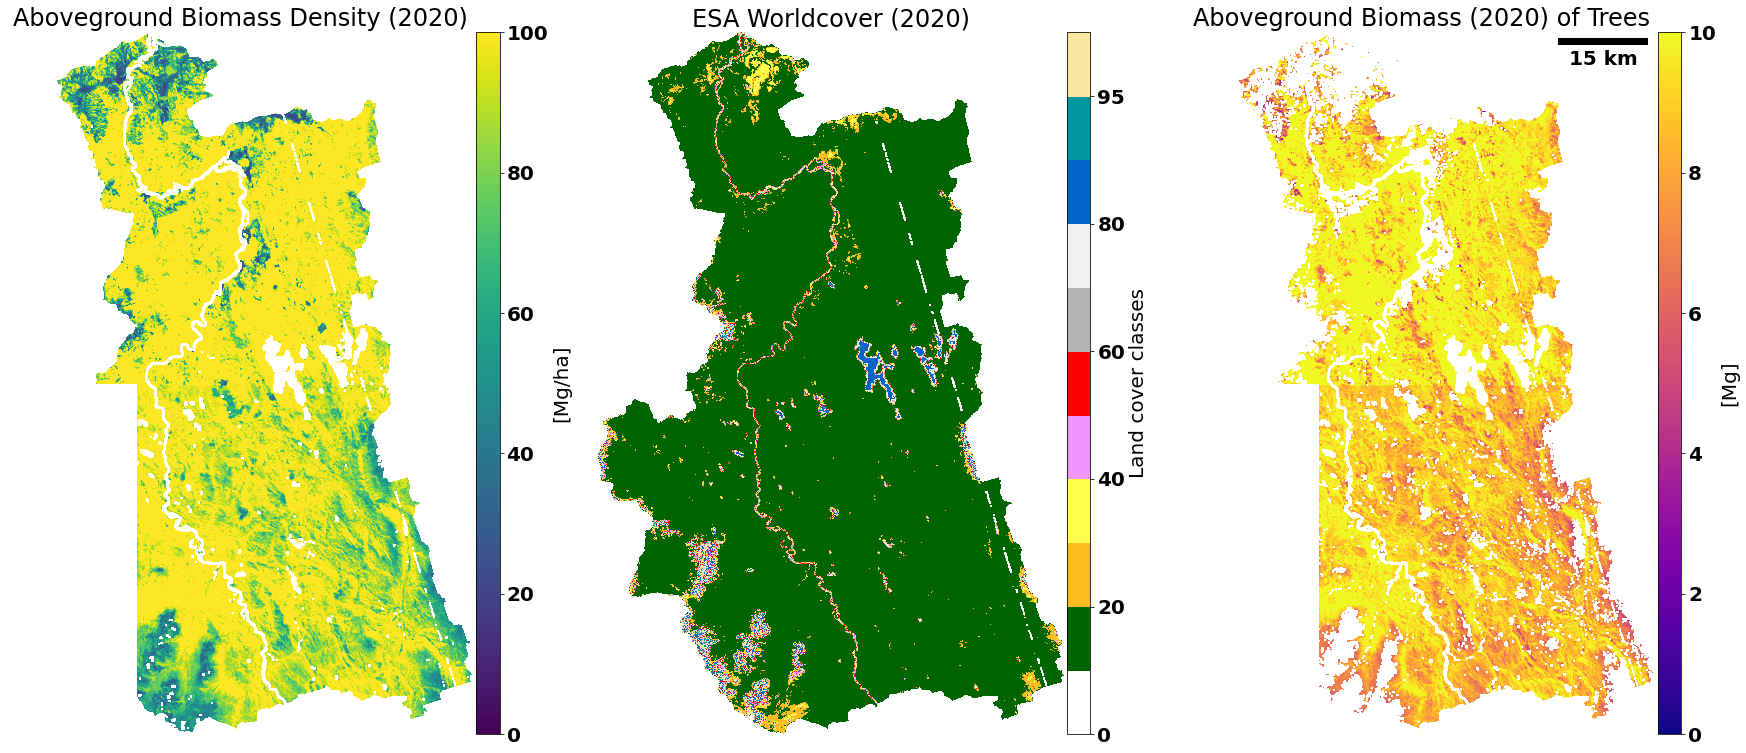

In [77]:
LC_VAL = 10
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(30,30), sharex=True, sharey=True)

# Scalebar doesnt seem correct
scalebar = ScaleBar(30) # <-- each pixel (unit) is 30m
plt.gca().add_artist(scalebar)

# AGB arrays
# With a water mask
agb_arr_masked = np.ma.masked_where( (lc_arr == 0  ) | (lc_arr == 80) , agb_arr)

# Without a water mask
#agb_arr_masked = np.ma.masked_where( (lc_arr == 0  )  ,agb_arr)

agb_arr_trees = np.ma.masked_where( (lc_arr != LC_VAL  ), agb_arr)

print(f"Extent:\t\t{TILE_NUM}")
print(f"Total ha.:\t\t{(agb_arr_masked[~np.isnan(agb_arr_masked)].count() * area_pix_ha ) }")
print(f"Mean Mg/ha:\t\t{ round(np.nanmean(agb_arr_masked),2) }")
print(f"Total Pg.:\t\t{round(np.nansum(agb_arr_masked)/1e9 * area_pix_ha,4) }")
print(f"Mean Mg/ha in trees:\t{ round(np.nanmean(agb_arr_trees),2) }")
print(f"Total Pg. in trees:\t{round(np.nansum(agb_arr_trees)/1e9 * area_pix_ha, 4) }")

# Plots
m1 = axes[0].imshow(agb_arr_masked, clim=(0,100) )
add_colorbar(m1, '[Mg/ha]')
m1 = axes[0].set_title('Aboveground Biomass Density (2020)')
axes[0].axis('off')

# Showing only trees LC
#m2 = axes[1].imshow(lc_arr_trees, cmap=cmap_worldcover, norm=norm_worldcover)
# Showing all LC classes
m2 = axes[1].imshow(lc_arr, cmap=cmap_worldcover, norm=norm_worldcover)
add_colorbar(m2, 'Land cover classes')
axes[1].set_title('ESA Worldcover (2020)')
axes[1].axis('off')

m3 = axes[2].imshow(np.ma.masked_where( lc_arr != LC_VAL, agb_arr * area_pix_ha), clim=(0,10), cmap='plasma')
add_colorbar(m3, '[Mg]')
m3 = axes[2].set_title('Aboveground Biomass (2020) of Trees')
axes[2].axis('off')

#### Masking sanity checking

In [78]:
agb_arr[agb_arr.mask == False].count() * 0.09

536660.19

In [254]:
lc_arr = np.array([0,10,20,30,40,10])
agb_arr = np.array([-9999.0,20.78,5.65,200.8,45.7,10.0])  

print(f"lc_arr shape: {lc_arr.shape}")
print(f"agb_arr shape: {agb_arr.shape}")

LC_VALUE = 10

# For LC value of interest, set to 1, else mask out
lc_agb_arr = np.ma.masked_where( (lc_arr == 0) | (agb_arr < 0) | (lc_arr!=LC_VALUE) , agb_arr)

num_lc_pixels_in_mask = lc_agb_arr.count()

print(f"\n# lc pixels in mask: {num_lc_pixels_in_mask}")

print(lc_agb_arr)
print(lc_agb_arr.sum())
print(np.median(lc_agb_arr))

lc_arr shape: (6,)
agb_arr shape: (6,)

# lc pixels in mask: 2
[10 10]
[-- 20.78 -- -- -- 10.0]
30.78
--


In [71]:
# TESTING aws_session stuff using creds in order to gain access to redentialed s3 data
if False:
    credentials_fn = BUILD_STACK_DICT_LIST[2]['CREDENTIALS_FN']
    #pd.read_csv(credentials_fn)

    import configparser

    config = configparser.ConfigParser()
    config.read(credentials_fn)
    profile_name = config.sections()[0]

    aws_access_key_id = config['boreal_pub']['aws_access_key_id']
    aws_secret_access_key = config['boreal_pub']['aws_secret_access_key']

    print(profile_name)
# trying to get aws creds
if False:
    import s3fs
    import rasterio as rio
    from rasterio.session import AWSSession
    import boto3
    import pandas as pd

    
    #aws_session = CovariateUtils.get_rio_aws_session_from_creds(credentials_fn)

    profile_name, aws_access_key_id, aws_secret_access_key = CovariateUtils.parse_aws_creds(credentials_fn)
    
    boto3_session = boto3.Session(
            aws_access_key_id=aws_access_key_id,
            aws_secret_access_key=aws_secret_access_key,
            #aws_session_token=credentials['SessionToken'],
            profile_name=profile_name
        )

    rio_aws_session = AWSSession(boto3_session)

### Build the VRT of the Worldcover covar data on s3 for the region

In [28]:
if False:
    for bandnum, bandname in bands_dict.items():

        print(bandnum, bandname)

        # Write a vrt list
        covar_vrt_list = os.path.join(OUTDIR_MAIN, f"cog_tindex.{bandname}.{tile_group_region_string}.txt")

        with open(covar_vrt_list, 'w') as f:

            for text in covar_footprint_tiles_subset['s3_path'].tolist():
                f.write(text.replace("s3:/","/vsis3") + '\n')

        # Make vrt name from text file name
        covar_vrt_fn = covar_vrt_list.replace('.txt','.vrt')

        #get the bbox as part of the gdalbuildvrt and define it, to save time calculating
        extent = [int(b) for b in covar_footprint_tiles_subset.total_bounds]

        extent_str = ' '.join(str(e) for e in extent)

        ###!time gdalbuildvrt -b 1 -te 458521 1503304 5408522 7623304 -input_file_list $vrt_list $vrt_fn
        !time gdalbuildvrt -b $bandnum -te $extent_str -input_file_list $covar_vrt_list $covar_vrt_fn
        print(covar_vrt_fn)

    vrt_fn = '/projects/my-public-bucket/analyze_agb/AGB_tindex_america.vrt'
    with rasterio.open(vrt_fn) as d:
        print(d.nodatavals)

1 esa_worldcover_v100_2020
0...10...20...30...40...50...60...70...80...90...100 - done.

real	1m0.068s
user	0m0.868s
sys	0m0.063s
